# Моделирование NVT ансамбля <a class="tocSkip">

   - Система: $N = 1372$ частиц;
   - Ячейка моделирования: $V = 12.25\sigma\times12.25\sigma\times12.25\sigma$;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Ансамбль: $NVT$;
   - Начальная температура: $T_i = 1.3~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-4}~\varepsilon / k_B$;
   - Скорости охлаждения: $\gamma = 4\times10^{-4}~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $2000000$;
   - Равновесные характеристики системы рассчитывалась через каждые $100000$ шагов;
   - Число шагов на уравновешивание системы при фиксированных внешних условиях: $M=15000$;
   - Число ансамблей $N=5000$;
   - Усреднение по ансамблям при фиксированных внешних условиях: $2N-1$ шагов (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

## Предварительные настройки

### Импорт необходимых библиотек, классов и функций

In [1]:
from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

In [2]:
from collections import Counter
from copy import deepcopy
from datetime import datetime
import os
import sys

from math import log10

In [3]:
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.plotter import Plotter, get_temperature_legend
import scripts.postprocessing as pp

%autoreload 2

In [5]:
COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
    'navy',
    'crimson',
    'goldenrod',
    'darkcyan',
    'dodgerblue',
    'saddlebrown',
)

default_cycler = cycler(color=COLORS)

plt.rc('axes', prop_cycle=default_cycler)

print(f'{len(COLORS)} colors are acceptable.')

25 colors are acceptable.


### Пути к файлам

In [6]:
CURRENT_DATA_SLOW = '2021-10-05_velocity_scaling_HV_4e-4_T_01e-4'
PLOT_FILENAME_POSTFIX_SLOW = 'cooling_slow'

In [7]:
PATH_TO_CURRENT_DATA_SLOW = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_DATA_SLOW

'C:\\albert\\git_reps\\molecular_dynamics\\data\\2021-10-05_velocity_scaling_HV_4e-4_T_01e-4'

In [8]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_PLOTS

'C:\\albert\\git_reps\\molecular_dynamics\\plots\\2021-10-05_velocity_scaling_HV_4e-4_T_01e-4'

### Пользовательские функции

In [9]:
def get_merged_data(
    old_data: pd.DataFrame,
    data_filename_prefix: str,
    merge_column_name: str,
    old_column_name: str,
    temperature: float,
    columns: list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(
        columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [10]:
def save_plot(filename):
    formats = ('.png', '.eps')
    _filename = filename
    for fmt in formats:
        if filename.endswith(fmt):
            _filename = _filename.removesuffix(fmt)
    for fmt in formats:
        plt.savefig(
            os.path.join(PATH_TO_CURRENT_PLOTS, f'{_filename}{fmt}'),
            bbox_inches='tight',
            pad_inches=0,
        )

## Параметры системы

In [11]:
setups_slow = []
rdf_slow = pp.RadialDistributionFunctionPP(path_to_data=PATH_TO_CURRENT_DATA_SLOW)

for filename in os.listdir(PATH_TO_CURRENT_DATA_SLOW)[::+1]:
    if filename.startswith('rdf') and filename.endswith('csv'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]),
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
        }
        setups_slow.append(setup)
        print(setup)
        filename_postfix = pp.get_filename_postfix(setup)
        rdf_slow.append(filename_postfix=filename_postfix)
        rdf_slow.rename_column(column_name='rdf', setup_number=len(setups_slow) - 1)

rdf_slow.data

{'temperature': 0.0001, 'pressure': -0.90479, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90488, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90495, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90506, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90539, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90551, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90552, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90559, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.9056, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90564, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90566, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90576, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.90604, 'heating_velocity': 0.0004}
{'temperature': 0.0001, 'pressure': -0.

,radius,setup_0,setup_1,setup_2,setup_3,setup_4,setup_5,setup_6,setup_7,setup_8,...,setup_11,setup_12,setup_13,setup_14,setup_15,setup_16,setup_17,setup_18,setup_19,setup_20
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,6.08,0.815419,0.815144,0.815176,0.815006,0.813873,0.815440,0.814381,0.815900,0.816255,...,0.815184,0.814805,0.814824,0.804452,0.881153,0.991425,1.004160,1.001966,1.003661,1.002347
608,6.09,0.798671,0.799023,0.799497,0.798485,0.799708,0.799188,0.799676,0.798171,0.798568,...,0.798532,0.798739,0.799336,0.814180,0.874698,0.990339,1.003921,1.002574,1.004290,1.002583
609,6.10,0.882917,0.882718,0.882353,0.882609,0.882272,0.882379,0.881597,0.882977,0.882143,...,0.882895,0.881947,0.882299,0.824412,0.870577,0.988672,1.004420,1.002326,1.004338,1.001176
610,6.11,0.872517,0.872736,0.872740,0.873188,0.873571,0.872654,0.874269,0.872873,0.872882,...,0.873146,0.873923,0.872600,0.836480,0.869395,0.988534,1.004190,1.001747,1.002872,1.001308


## Функция радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

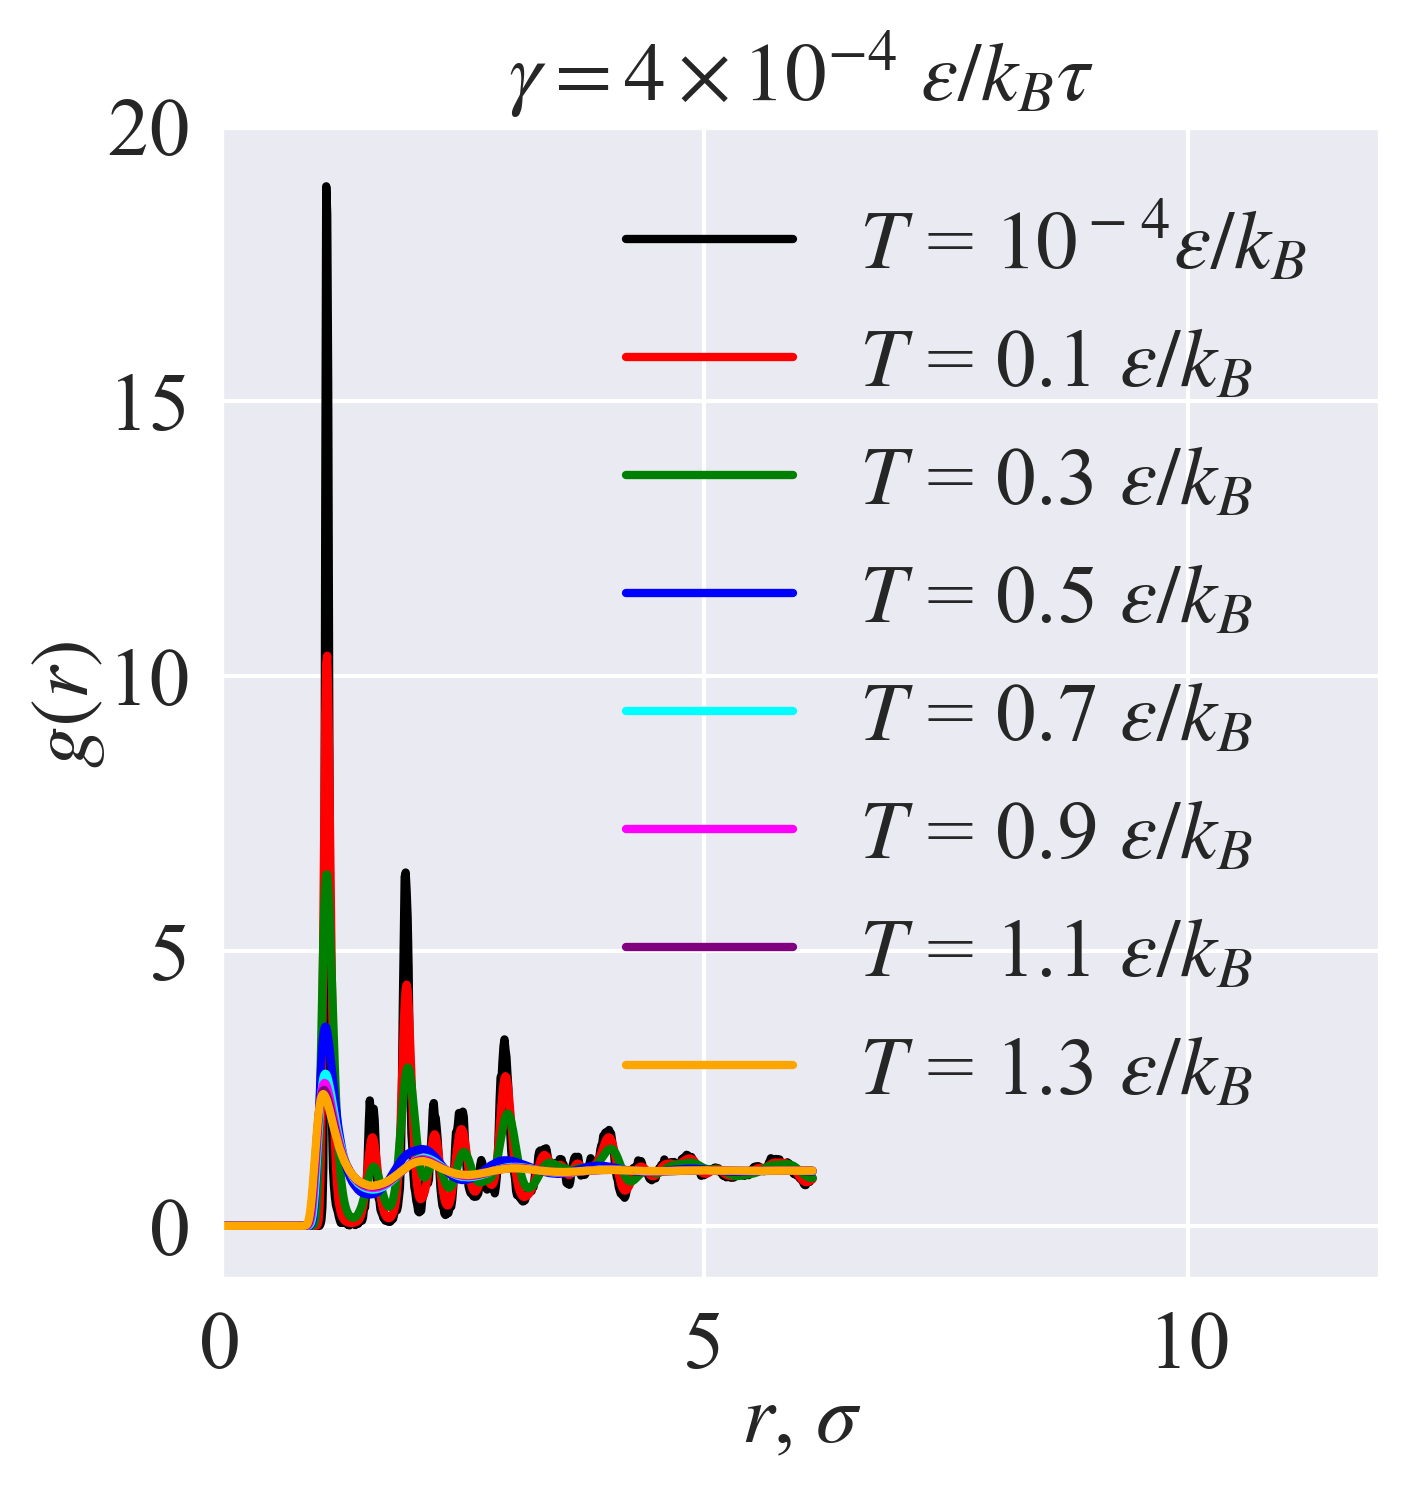

In [12]:
plotter = Plotter(
    path_to_plots=PATH_TO_CURRENT_PLOTS,
    limits=dict(
        left=0,
        right=12,
        bottom=-1,
        top=20,
    ),
    size=(5, 5),
    labels=('radius', 'rdf'),
)

shown=list(range(len(setups_slow)))[-8:]
shift = 0
for i, setup in enumerate(setups_slow):
    if shown is not None and i not in shown:
        continue
    plotter.ax.plot(
        rdf_slow.data['radius'],
        (rdf_slow.data[f'setup_{i}'] + shift * (len(setups_slow) - (i + 1))),
        label=get_temperature_legend(setup["temperature"], accuracy=1),
        color=COLORS[i - shown[0]],
    )

plotter.get_legend()
plotter.save_plot(filename=f'rdf_{PLOT_FILENAME_POSTFIX_SLOW}.png')
plotter.set_title(r'$\gamma = 4\times10^{-4}~\varepsilon / k_B\tau$')
plt.show()

## Таблица значений RDF

In [13]:
rdf_table = rdf_slow.get_rdf_table()
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
setup_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002700,1.002247,1.002563,1.001981,1.002192,1.002347,1.002583,1.001176,1.001308,1.001091
setup_19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003908,1.003666,1.003148,1.002556,1.003853,1.003661,1.004290,1.004338,1.002872,1.002322
setup_18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004169,1.003481,1.002693,1.003470,1.002877,1.001966,1.002574,1.002326,1.001747,1.001260
setup_17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004417,1.003834,1.003803,1.004715,1.004226,1.004160,1.003921,1.004420,1.004190,1.002844
setup_16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996056,0.995827,0.994320,0.992058,0.991444,0.991425,0.990339,0.988672,0.988534,0.987143
setup_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.933198,0.919905,0.909229,0.898541,0.888932,0.881153,0.874698,0.870577,0.869395,0.868474
setup_14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.811611,0.801218,0.796138,0.794453,0.797800,0.804452,0.814180,0.824412,0.836480,0.847419
setup_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.761771,0.741715,0.740405,0.792817,0.809825,0.814824,0.799336,0.882299,0.872600,0.870090
setup_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.761304,0.742173,0.739909,0.793012,0.809523,0.814805,0.798739,0.881947,0.873923,0.869410
setup_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.761249,0.742528,0.739562,0.793590,0.808716,0.815184,0.798532,0.882895,0.873146,0.870247


## Температура системы как признак модели

In [14]:
temperatures = np.array([
    setups_slow[value]['temperature']
    for value
    in rdf_table.index.str[6:].values.astype(np.int32)
])
samples = temperatures[:, np.newaxis]
samples

array([[1.30085e+00],
       [1.10428e+00],
       [9.03840e-01],
       [6.99210e-01],
       [5.02010e-01],
       [3.01010e-01],
       [1.01000e-01],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04],
       [1.00000e-04]])

In [15]:
np.random.seed(0)
samples_indices = np.arange(samples.shape[0])
np.random.shuffle(samples_indices)
samples_train_indices = samples_indices[:samples_indices.size // 2]
samples_test_indices = samples_indices[samples_indices.size // 2:]

train_samples = samples[samples_train_indices]
test_samples = samples[samples_test_indices]

samples_train_indices, samples_test_indices

(array([ 8, 13, 20,  1, 11, 10, 14, 18,  6, 19]),
 array([ 4,  2,  5, 16,  9,  7, 17,  3,  0, 15, 12]))

In [16]:
train_samples, test_samples

(array([[1.00000e-04],
        [1.00000e-04],
        [1.00000e-04],
        [1.10428e+00],
        [1.00000e-04],
        [1.00000e-04],
        [1.00000e-04],
        [1.00000e-04],
        [1.01000e-01],
        [1.00000e-04]]),
 array([[5.02010e-01],
        [9.03840e-01],
        [3.01010e-01],
        [1.00000e-04],
        [1.00000e-04],
        [1.00000e-04],
        [1.00000e-04],
        [6.99210e-01],
        [1.30085e+00],
        [1.00000e-04],
        [1.00000e-04]]))

## Настройка гиперпараметров

In [17]:
# regressors = {
#     'linear': LinearRegression(), 
#     'k_neighbors_uniform': KNeighborsRegressor(weights='uniform'), 
#     'k_neighbors_distance': KNeighborsRegressor(weights='distance'), 
#     'r_neighbors_uniform': RadiusNeighborsRegressor(weights='uniform'), 
#     'r_neighbors_distance': RadiusNeighborsRegressor(weights='distance'), 
#     'decision_tree': DecisionTreeRegressor(),
# }
# scores = {key: [] for key in regressors.keys()}
# param_names = {
#     'k_neighbors_uniform': 'n_neighbors', 
#     'k_neighbors_distance': 'n_neighbors', 
#     'r_neighbors_uniform': 'radius', 
#     'r_neighbors_distance': 'radius',
#     'decision_tree': 'max_depth',
# }
# param_ranges = {
#     'k_neighbors_uniform': np.arange(1, 15),
#     'k_neighbors_distance': np.arange(1, 15),
#     'r_neighbors_uniform': np.linspace(0.4, 1.3, 10),
#     'r_neighbors_distance': np.linspace(0.4, 1.3, 10),
#     'decision_tree': np.arange(1, 15),
# }

# for i, column in enumerate(rdf_table.columns):
#     print(f'Step: {i + 1} / {rdf_table.columns.shape[0]}')
#     train_targets = rdf_table[column].values[samples_train_indices]
#     if not train_targets.any():
#         continue
#     for key in list(regressors.keys())[1:]:
#         _, test_scores = validation_curve(
#             regressors[key],
#             train_samples, train_targets,
#             param_name=param_names[key],
#             param_range=np.arange(1, 9),
#             scoring='neg_mean_squared_error',
#             cv=train_samples.shape[0],
#         )
#         scores[key].append(np.mean(test_scores, axis=1).argmax())

# best_hyperparameters = {}
# for key, value in scores.items():
#     if value:
#         best_hyperparameters[key] = param_ranges[key][
#             Counter(value).most_common(1)[0][0]
#         ]
        
# best_hyperparameters

Step: 1 / 612
Step: 2 / 612
Step: 3 / 612
Step: 4 / 612
Step: 5 / 612
Step: 6 / 612
Step: 7 / 612
Step: 8 / 612
Step: 9 / 612
Step: 10 / 612
Step: 11 / 612
Step: 12 / 612
Step: 13 / 612
Step: 14 / 612
Step: 15 / 612
Step: 16 / 612
Step: 17 / 612
Step: 18 / 612
Step: 19 / 612
Step: 20 / 612
Step: 21 / 612
Step: 22 / 612
Step: 23 / 612
Step: 24 / 612
Step: 25 / 612
Step: 26 / 612
Step: 27 / 612
Step: 28 / 612
Step: 29 / 612
Step: 30 / 612
Step: 31 / 612
Step: 32 / 612
Step: 33 / 612
Step: 34 / 612
Step: 35 / 612
Step: 36 / 612
Step: 37 / 612
Step: 38 / 612
Step: 39 / 612
Step: 40 / 612
Step: 41 / 612
Step: 42 / 612
Step: 43 / 612
Step: 44 / 612
Step: 45 / 612
Step: 46 / 612
Step: 47 / 612
Step: 48 / 612
Step: 49 / 612
Step: 50 / 612
Step: 51 / 612
Step: 52 / 612
Step: 53 / 612
Step: 54 / 612
Step: 55 / 612
Step: 56 / 612
Step: 57 / 612
Step: 58 / 612
Step: 59 / 612
Step: 60 / 612
Step: 61 / 612
Step: 62 / 612
Step: 63 / 612
Step: 64 / 612
Step: 65 / 612
Step: 66 / 612
Step: 67 / 612
Step

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 86 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 87 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 88 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 89 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 90 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 91 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 92 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 93 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 94 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 95 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 96 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 97 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 98 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 99 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 100 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 101 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", lin

Step: 102 / 612



KeyboardInterrupt



## Обучение модели

In [18]:
regressors_list = []
scores_dict = {
    'linear': [],
    'k_neighbors_uniform': [],
    'k_neighbors_distance': [],
    'r_neighbors_uniform': [],
    'r_neighbors_distance': [],
    'decision_tree': [],
}

for i, column in enumerate(rdf_table.columns):
    print(f'Step: {i + 1} / {rdf_table.columns.shape[0]}')
    train_targets = rdf_table[column].values[samples_train_indices]
    regressors = {
        'linear': LinearRegression(),
        'k_neighbors_uniform': KNeighborsRegressor(n_neighbors=1, weights='uniform'),
        'k_neighbors_distance': KNeighborsRegressor(n_neighbors=1, weights='distance'),
        'r_neighbors_uniform': RadiusNeighborsRegressor(radius=0.4, weights='uniform'),
        'r_neighbors_distance': RadiusNeighborsRegressor(radius=0.4, weights='distance'),
        'decision_tree': DecisionTreeRegressor(max_depth=2,),
    }
    for key, value in regressors.items():
        score = cross_val_score(
            value, 
            train_samples, train_targets,
            scoring='neg_mean_squared_error',
            cv=train_samples.shape[0],
        ).mean()
        scores_dict[key].append(score)
        regressors[key].fit(train_samples, train_targets)
    regressors_list.append(regressors)

for key, value in scores_dict.items():
    scores_dict[key] = np.array(value)

Step: 1 / 612
Step: 2 / 612
Step: 3 / 612
Step: 4 / 612
Step: 5 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 6 / 612
Step: 7 / 612
Step: 8 / 612
Step: 9 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 10 / 612
Step: 11 / 612
Step: 12 / 612
Step: 13 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 14 / 612
Step: 15 / 612
Step: 16 / 612
Step: 17 / 612
Step: 18 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 19 / 612
Step: 20 / 612
Step: 21 / 612
Step: 22 / 612
Step: 23 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 24 / 612
Step: 25 / 612
Step: 26 / 612
Step: 27 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 28 / 612
Step: 29 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 30 / 612
Step: 31 / 612
Step: 32 / 612
Step: 33 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 34 / 612
Step: 35 / 612
Step: 36 / 612
Step: 37 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 38 / 612
Step: 39 / 612
Step: 40 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 41 / 612
Step: 42 / 612
Step: 43 / 612
Step: 44 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 45 / 612
Step: 46 / 612
Step: 47 / 612
Step: 48 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 49 / 612
Step: 50 / 612
Step: 51 / 612
Step: 52 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 53 / 612
Step: 54 / 612
Step: 55 / 612
Step: 56 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 57 / 612
Step: 58 / 612
Step: 59 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 60 / 612
Step: 61 / 612
Step: 62 / 612
Step: 63 / 612
Step: 64 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 65 / 612
Step: 66 / 612
Step: 67 / 612
Step: 68 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 69 / 612
Step: 70 / 612
Step: 71 / 612
Step: 72 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 73 / 612
Step: 74 / 612
Step: 75 / 612
Step: 76 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 77 / 612
Step: 78 / 612
Step: 79 / 612
Step: 80 / 612
Step: 81 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 82 / 612
Step: 83 / 612
Step: 84 / 612
Step: 85 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 86 / 612
Step: 87 / 612
Step: 88 / 612
Step: 89 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 90 / 612
Step: 91 / 612
Step: 92 / 612
Step: 93 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 94 / 612
Step: 95 / 612
Step: 96 / 612
Step: 97 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 98 / 612
Step: 99 / 612
Step: 100 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 101 / 612
Step: 102 / 612
Step: 103 / 612
Step: 104 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 105 / 612
Step: 106 / 612
Step: 107 / 612
Step: 108 / 612
Step: 109 / 612
Step: 110 / 612
Step: 111 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 112 / 612
Step: 113 / 612
Step: 114 / 612
Step: 115 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 116 / 612
Step: 117 / 612
Step: 118 / 612
Step: 119 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 120 / 612
Step: 121 / 612
Step: 122 / 612
Step: 123 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 124 / 612
Step: 125 / 612
Step: 126 / 612
Step: 127 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 128 / 612
Step: 129 / 612
Step: 130 / 612
Step: 131 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 132 / 612
Step: 133 / 612
Step: 134 / 612
Step: 135 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 136 / 612
Step: 137 / 612
Step: 138 / 612
Step: 139 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 140 / 612
Step: 141 / 612
Step: 142 / 612
Step: 143 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 144 / 612
Step: 145 / 612
Step: 146 / 612
Step: 147 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 148 / 612
Step: 149 / 612
Step: 150 / 612
Step: 151 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 152 / 612
Step: 153 / 612
Step: 154 / 612
Step: 155 / 612
Step: 156 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 157 / 612
Step: 158 / 612
Step: 159 / 612
Step: 160 / 612
Step: 161 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 162 / 612
Step: 163 / 612
Step: 164 / 612
Step: 165 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 166 / 612
Step: 167 / 612
Step: 168 / 612
Step: 169 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 170 / 612
Step: 171 / 612
Step: 172 / 612
Step: 173 / 612
Step: 174 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 175 / 612
Step: 176 / 612
Step: 177 / 612
Step: 178 / 612
Step: 179 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 180 / 612
Step: 181 / 612
Step: 182 / 612
Step: 183 / 612
Step: 184 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 185 / 612
Step: 186 / 612
Step: 187 / 612
Step: 188 / 612
Step: 189 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 190 / 612
Step: 191 / 612
Step: 192 / 612
Step: 193 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 194 / 612
Step: 195 / 612
Step: 196 / 612
Step: 197 / 612
Step: 198 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 199 / 612
Step: 200 / 612
Step: 201 / 612
Step: 202 / 612
Step: 203 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 204 / 612
Step: 205 / 612
Step: 206 / 612
Step: 207 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 208 / 612
Step: 209 / 612
Step: 210 / 612
Step: 211 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 212 / 612
Step: 213 / 612
Step: 214 / 612
Step: 215 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 216 / 612
Step: 217 / 612
Step: 218 / 612
Step: 219 / 612
Step: 220 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 221 / 612
Step: 222 / 612
Step: 223 / 612
Step: 224 / 612
Step: 225 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 226 / 612
Step: 227 / 612
Step: 228 / 612
Step: 229 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 230 / 612
Step: 231 / 612
Step: 232 / 612
Step: 233 / 612
Step: 234 / 612
Step: 235 / 612
Step: 236 / 612
Step: 237 / 612
Step: 238 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 239 / 612
Step: 240 / 612
Step: 241 / 612
Step: 242 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 243 / 612
Step: 244 / 612
Step: 245 / 612
Step: 246 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 247 / 612
Step: 248 / 612
Step: 249 / 612
Step: 250 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 251 / 612
Step: 252 / 612
Step: 253 / 612
Step: 254 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 255 / 612
Step: 256 / 612
Step: 257 / 612
Step: 258 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 259 / 612
Step: 260 / 612
Step: 261 / 612
Step: 262 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 263 / 612
Step: 264 / 612
Step: 265 / 612
Step: 266 / 612
Step: 267 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 268 / 612
Step: 269 / 612
Step: 270 / 612
Step: 271 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 272 / 612
Step: 273 / 612
Step: 274 / 612
Step: 275 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 276 / 612
Step: 277 / 612
Step: 278 / 612
Step: 279 / 612
Step: 280 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 281 / 612
Step: 282 / 612
Step: 283 / 612
Step: 284 / 612
Step: 285 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 286 / 612
Step: 287 / 612
Step: 288 / 612
Step: 289 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 290 / 612
Step: 291 / 612
Step: 292 / 612
Step: 293 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 294 / 612
Step: 295 / 612
Step: 296 / 612
Step: 297 / 612
Step: 298 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 299 / 612
Step: 300 / 612
Step: 301 / 612
Step: 302 / 612
Step: 303 / 612
Step: 304 / 612
Step: 305 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 306 / 612
Step: 307 / 612
Step: 308 / 612
Step: 309 / 612
Step: 310 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 311 / 612
Step: 312 / 612
Step: 313 / 612
Step: 314 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 315 / 612
Step: 316 / 612
Step: 317 / 612
Step: 318 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 319 / 612
Step: 320 / 612
Step: 321 / 612
Step: 322 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 323 / 612
Step: 324 / 612
Step: 325 / 612
Step: 326 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 327 / 612
Step: 328 / 612
Step: 329 / 612
Step: 330 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 331 / 612
Step: 332 / 612
Step: 333 / 612
Step: 334 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 335 / 612
Step: 336 / 612
Step: 337 / 612
Step: 338 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 339 / 612
Step: 340 / 612
Step: 341 / 612
Step: 342 / 612
Step: 343 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 344 / 612
Step: 345 / 612
Step: 346 / 612
Step: 347 / 612
Step: 348 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 349 / 612
Step: 350 / 612
Step: 351 / 612
Step: 352 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 353 / 612
Step: 354 / 612
Step: 355 / 612
Step: 356 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 357 / 612
Step: 358 / 612
Step: 359 / 612
Step: 360 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 361 / 612
Step: 362 / 612
Step: 363 / 612
Step: 364 / 612
Step: 365 / 612
Step: 366 / 612
Step: 367 / 612
Step: 368 / 612
Step: 369 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 370 / 612
Step: 371 / 612
Step: 372 / 612
Step: 373 / 612
Step: 374 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 375 / 612
Step: 376 / 612
Step: 377 / 612
Step: 378 / 612
Step: 379 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 380 / 612
Step: 381 / 612
Step: 382 / 612
Step: 383 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 384 / 612
Step: 385 / 612
Step: 386 / 612
Step: 387 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 388 / 612
Step: 389 / 612
Step: 390 / 612
Step: 391 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 392 / 612
Step: 393 / 612
Step: 394 / 612
Step: 395 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 396 / 612
Step: 397 / 612
Step: 398 / 612
Step: 399 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 400 / 612
Step: 401 / 612
Step: 402 / 612
Step: 403 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 404 / 612
Step: 405 / 612
Step: 406 / 612
Step: 407 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 408 / 612
Step: 409 / 612
Step: 410 / 612
Step: 411 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 412 / 612
Step: 413 / 612
Step: 414 / 612
Step: 415 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 416 / 612
Step: 417 / 612
Step: 418 / 612
Step: 419 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 420 / 612
Step: 421 / 612
Step: 422 / 612
Step: 423 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 424 / 612
Step: 425 / 612
Step: 426 / 612
Step: 427 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 428 / 612
Step: 429 / 612
Step: 430 / 612
Step: 431 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 432 / 612
Step: 433 / 612
Step: 434 / 612
Step: 435 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 436 / 612
Step: 437 / 612
Step: 438 / 612
Step: 439 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 440 / 612
Step: 441 / 612
Step: 442 / 612
Step: 443 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 444 / 612
Step: 445 / 612
Step: 446 / 612
Step: 447 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 448 / 612
Step: 449 / 612
Step: 450 / 612
Step: 451 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 452 / 612
Step: 453 / 612
Step: 454 / 612
Step: 455 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 456 / 612
Step: 457 / 612
Step: 458 / 612
Step: 459 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 460 / 612
Step: 461 / 612
Step: 462 / 612
Step: 463 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 464 / 612
Step: 465 / 612
Step: 466 / 612
Step: 467 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 468 / 612
Step: 469 / 612
Step: 470 / 612
Step: 471 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 472 / 612
Step: 473 / 612
Step: 474 / 612
Step: 475 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 476 / 612
Step: 477 / 612
Step: 478 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 479 / 612
Step: 480 / 612
Step: 481 / 612
Step: 482 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 483 / 612
Step: 484 / 612
Step: 485 / 612
Step: 486 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 487 / 612
Step: 488 / 612
Step: 489 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 490 / 612
Step: 491 / 612
Step: 492 / 612
Step: 493 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 494 / 612
Step: 495 / 612
Step: 496 / 612
Step: 497 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 498 / 612
Step: 499 / 612
Step: 500 / 612
Step: 501 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 502 / 612
Step: 503 / 612
Step: 504 / 612
Step: 505 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 506 / 612
Step: 507 / 612
Step: 508 / 612
Step: 509 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 510 / 612
Step: 511 / 612
Step: 512 / 612
Step: 513 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 514 / 612
Step: 515 / 612
Step: 516 / 612
Step: 517 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 518 / 612
Step: 519 / 612
Step: 520 / 612
Step: 521 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 522 / 612
Step: 523 / 612
Step: 524 / 612
Step: 525 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 526 / 612
Step: 527 / 612
Step: 528 / 612
Step: 529 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 530 / 612
Step: 531 / 612
Step: 532 / 612
Step: 533 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 534 / 612
Step: 535 / 612
Step: 536 / 612
Step: 537 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 538 / 612
Step: 539 / 612
Step: 540 / 612
Step: 541 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 542 / 612
Step: 543 / 612
Step: 544 / 612
Step: 545 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 546 / 612
Step: 547 / 612
Step: 548 / 612
Step: 549 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 550 / 612
Step: 551 / 612
Step: 552 / 612
Step: 553 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 554 / 612
Step: 555 / 612
Step: 556 / 612
Step: 557 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 558 / 612
Step: 559 / 612
Step: 560 / 612
Step: 561 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 562 / 612
Step: 563 / 612
Step: 564 / 612
Step: 565 / 612
Step: 566 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 567 / 612
Step: 568 / 612
Step: 569 / 612
Step: 570 / 612
Step: 571 / 612
Step: 572 / 612
Step: 573 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 574 / 612
Step: 575 / 612
Step: 576 / 612
Step: 577 / 612
Step: 578 / 612
Step: 579 / 612
Step: 580 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

Step: 581 / 612
Step: 582 / 612
Step: 583 / 612
Step: 584 / 612
Step: 585 / 612
Step: 586 / 612
Step: 587 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 588 / 612
Step: 589 / 612
Step: 590 / 612
Step: 591 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 592 / 612
Step: 593 / 612
Step: 594 / 612
Step: 595 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 596 / 612
Step: 597 / 612
Step: 598 / 612
Step: 599 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 600 / 612
Step: 601 / 612
Step: 602 / 612
Step: 603 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 604 / 612
Step: 605 / 612
Step: 606 / 612
Step: 607 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_regres

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

Step: 608 / 612
Step: 609 / 612
Step: 610 / 612
Step: 611 / 612
Step: 612 / 612


C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\Envs\md_env\lib\site-pa

## Визуализация ошибок

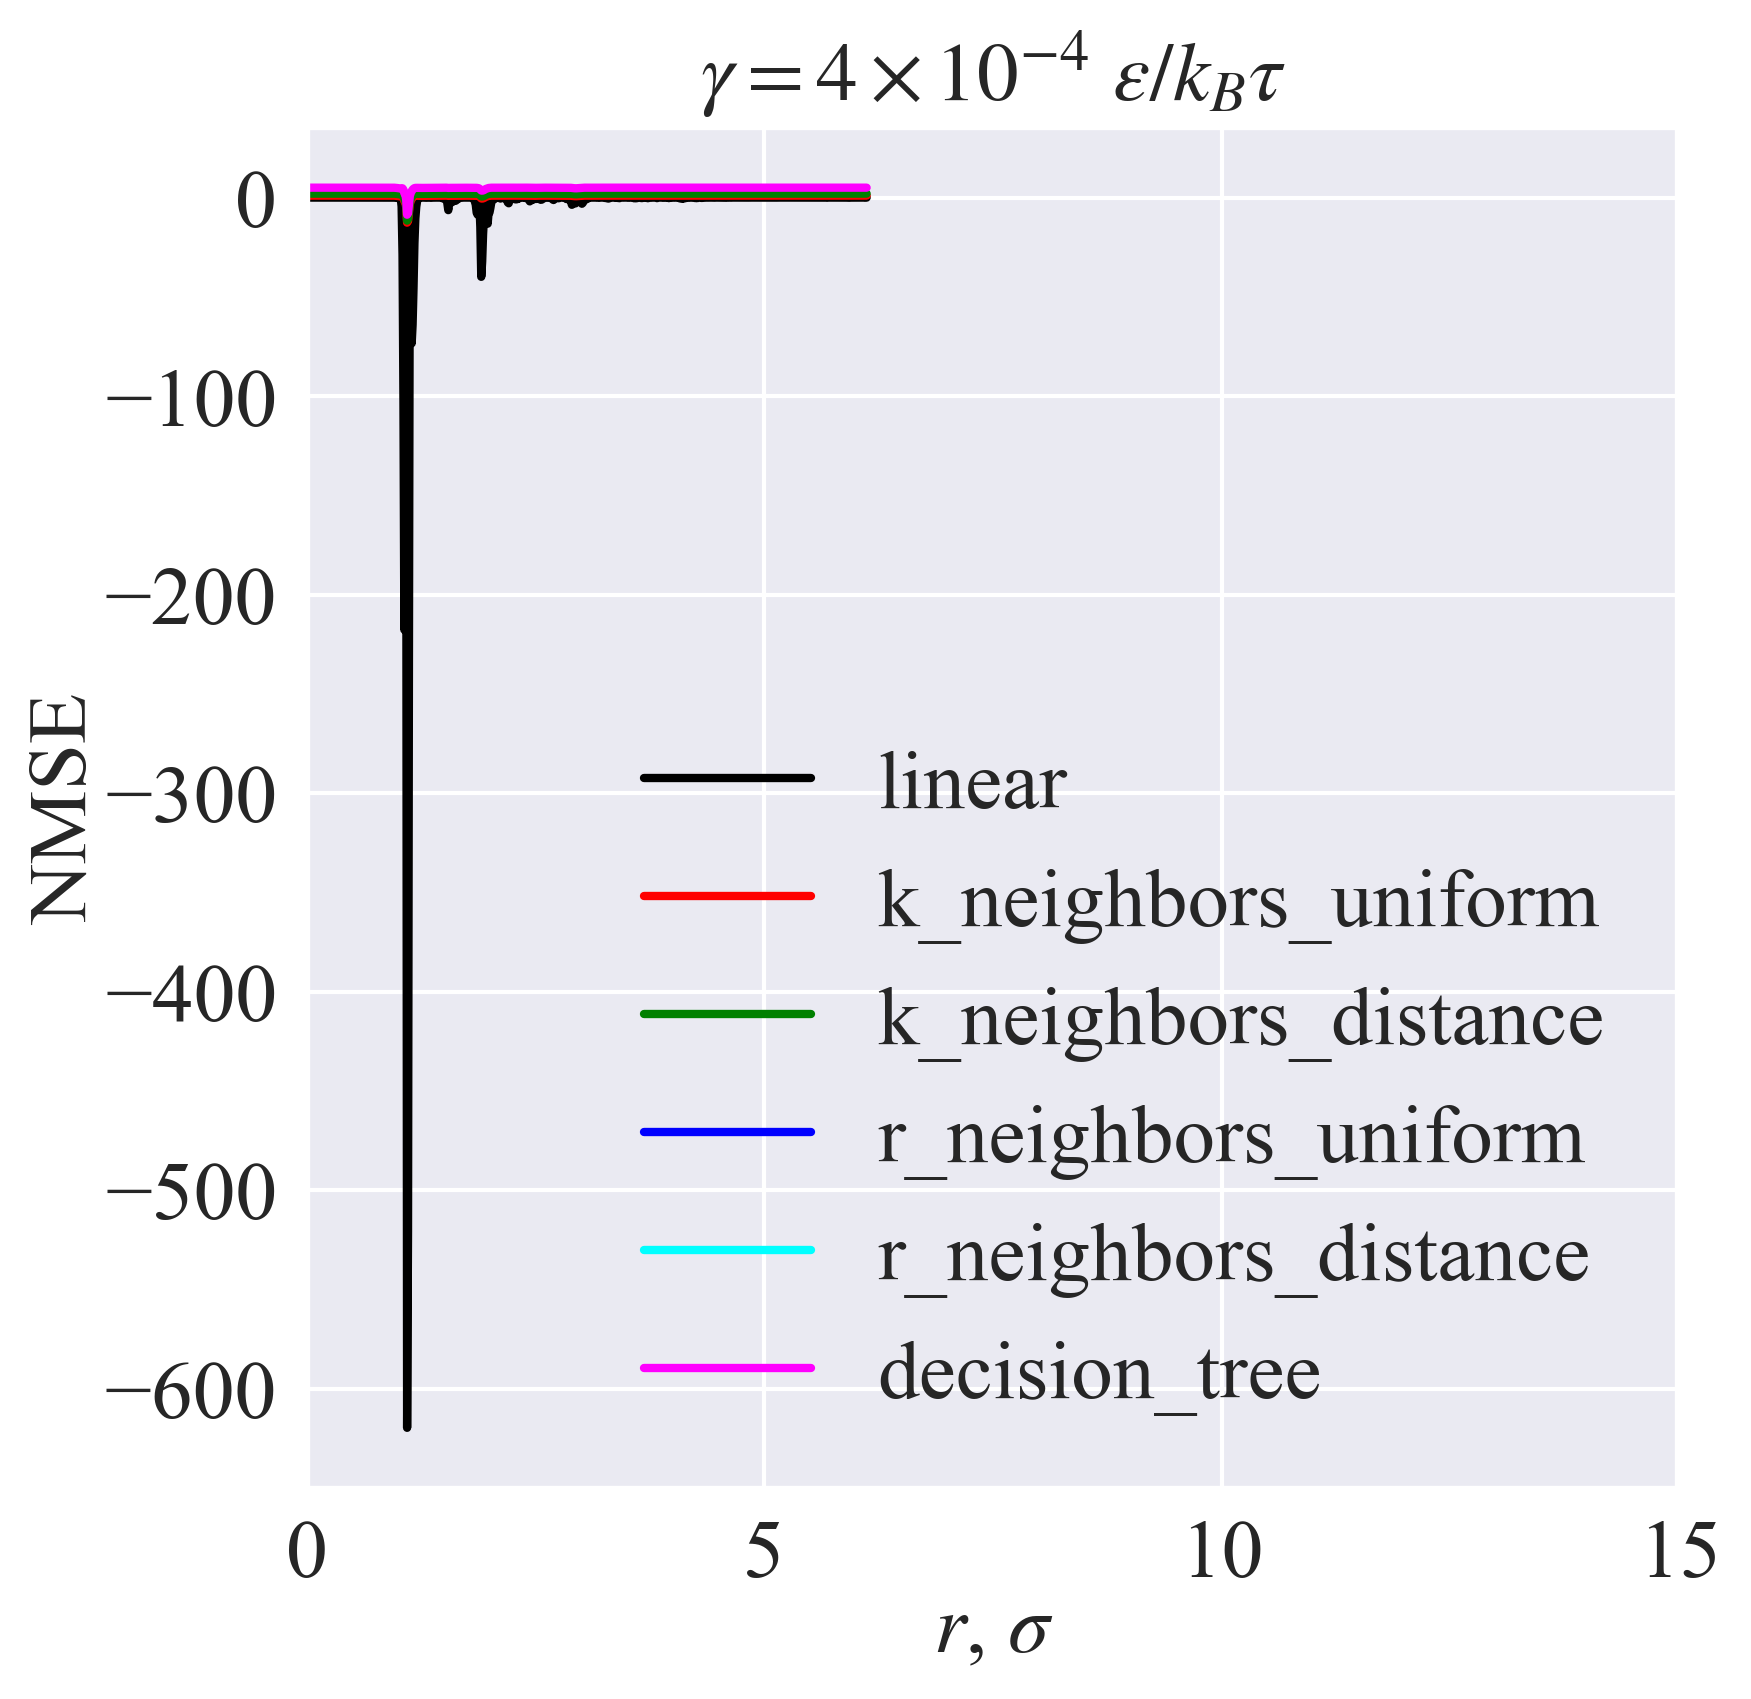

In [19]:
i = 0
for key, value in scores_dict.items():
    plt.plot(
        rdf_slow.data['radius'],
        value + i, label=key, 
        color=COLORS[i],
    )
    i += 1
plt.legend()
plt.xlim(
    left=0.0,
    right=15,
)
plt.ylim(
    #     top=0.01,
    #     bottom=-0.25,
)
plt.xlabel(r'$r$, $\sigma $')
plt.ylabel('NMSE')
plt.title(r'$\gamma = 4\times10^{-4}~\varepsilon / k_B\tau$')
save_plot('mse_after_cv')

In [20]:
predicted_temperatures = np.array(test_samples)

predicted_rdf_points = {
    regressor: {key: [] for key in predicted_temperatures[:, 0]}
    for regressor in scores_dict.keys()
}

for item in regressors_list:
    for key, value in item.items():
        predicted_data = value.predict(predicted_temperatures)
        for _key, _ in predicted_rdf_points[key].items():
            predicted_rdf_points[key][_key].append(
                predicted_data[np.where(predicted_temperatures[:, 0] == _key)][0]
            )

for key, value in predicted_rdf_points.items():
    for _key, _value in value.items():
        predicted_rdf_points[key][_key] = np.array(_value)

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:482: UserWarning: One or more samples have no neighbors within specified radius; predic

In [21]:
for i, temperature in zip(samples_test_indices, predicted_temperatures):
    print(i, temperature[0])

4 0.50201
2 0.90384
5 0.30101
16 0.0001
9 0.0001
7 0.0001
17 0.0001
3 0.69921
0 1.30085
15 0.0001
12 0.0001


In [22]:
# for key, value in predicted_rdf_points.items():
#     plotter = Plotter(
#         path_to_plots=PATH_TO_CURRENT_PLOTS,
#         limits=dict(
#             left=0,
#             right=12,
#             bottom=-1,
#             top=20,
#         ),
#         size=(6, 6),
#         labels=('radius', 'rdf'),
#     )
#     plotter.ax.set_title(fr'{key} ($\gamma = 4\times10^{{-4}}~\varepsilon / k_B\tau$)')
#     shown_temperatures = []
#     for i, setup in enumerate(setups_slow):
#         temperature = setup["temperature"]
#         if temperature not in predicted_temperatures:
#             continue
#         if round(temperature, 4) in shown_temperatures:
#             continue
#         else:
#             shift_scale = 2
#             plotter.ax.plot(
#                 rdf_slow.data['radius'],
#                 rdf_slow.data[f'setup_{i}'] + shift_scale * len(shown_temperatures),
#                 label=get_temperature_legend(temperature, 4) + ' (Direct MD)',
#             )
#             plotter.ax.plot(
#                 rdf_table.columns.values,
#                 value[temperature] + shift_scale * len(shown_temperatures),
#                 '--',
#                 label=get_temperature_legend(temperature, 4) + ' (Regression)',
#             )
#             shown_temperatures.append(round(temperature, 4))

#     plotter.ax.legend(fontsize=10)
#     plotter.save_plot(f'rdf_with_predicted_cooling_{key}.png')
#     plt.show()

In [23]:
# max_mse = {
#     'names': [],
# }

# for key, value in predicted_rdf_points.items():
#     name = ''.join([item[0].upper() for item in key.split('_')])
#     max_mse['names'].append(name)
    
#     plotter = Plotter(
#         path_to_plots=PATH_TO_CURRENT_PLOTS,
#         limits=dict(
#             left=0,
#             right=12,
# #             bottom=-1,
# #             top=14,
#         ),
#         size=(15, 15),
#         labels=('radius', 'MSE'),
#     )
#     plotter.ax.set_title(fr'{key} ($\gamma = 4\times10^{{-4}}~\varepsilon / k_B\tau$)')
    
#     shown_temperatures = []
#     for i, setup in enumerate(setups_slow):
#         temperature = setup["temperature"]
#         if temperature not in predicted_temperatures:
#             continue
#         if round(temperature, 4) in shown_temperatures:
#             continue
#         else:
#             mse = (
#                 value[temperature]
#                 - rdf_slow.data[f'setup_{i}']
#             ) ** 2 / rdf_table.columns.values.size
#             try:
#                 max_mse[temperature].append(mse.max())
#             except KeyError:
#                 max_mse[temperature] = [mse.max()]
#             plotter.ax.plot(
#                 rdf_table.columns.values,
#                 mse + 0.01 * len(shown_temperatures),
#                 label=get_temperature_legend(temperature, 4),
#             )
#             shown_temperatures.append(round(temperature, 4))

#     plotter.ax.legend()
#     plotter.save_plot(f'rdf_mse_cooling_{key}.png')
#     plt.show()
#     save_plot(f'rdf_mse_cooling_{key}.png')
#     plt.show()

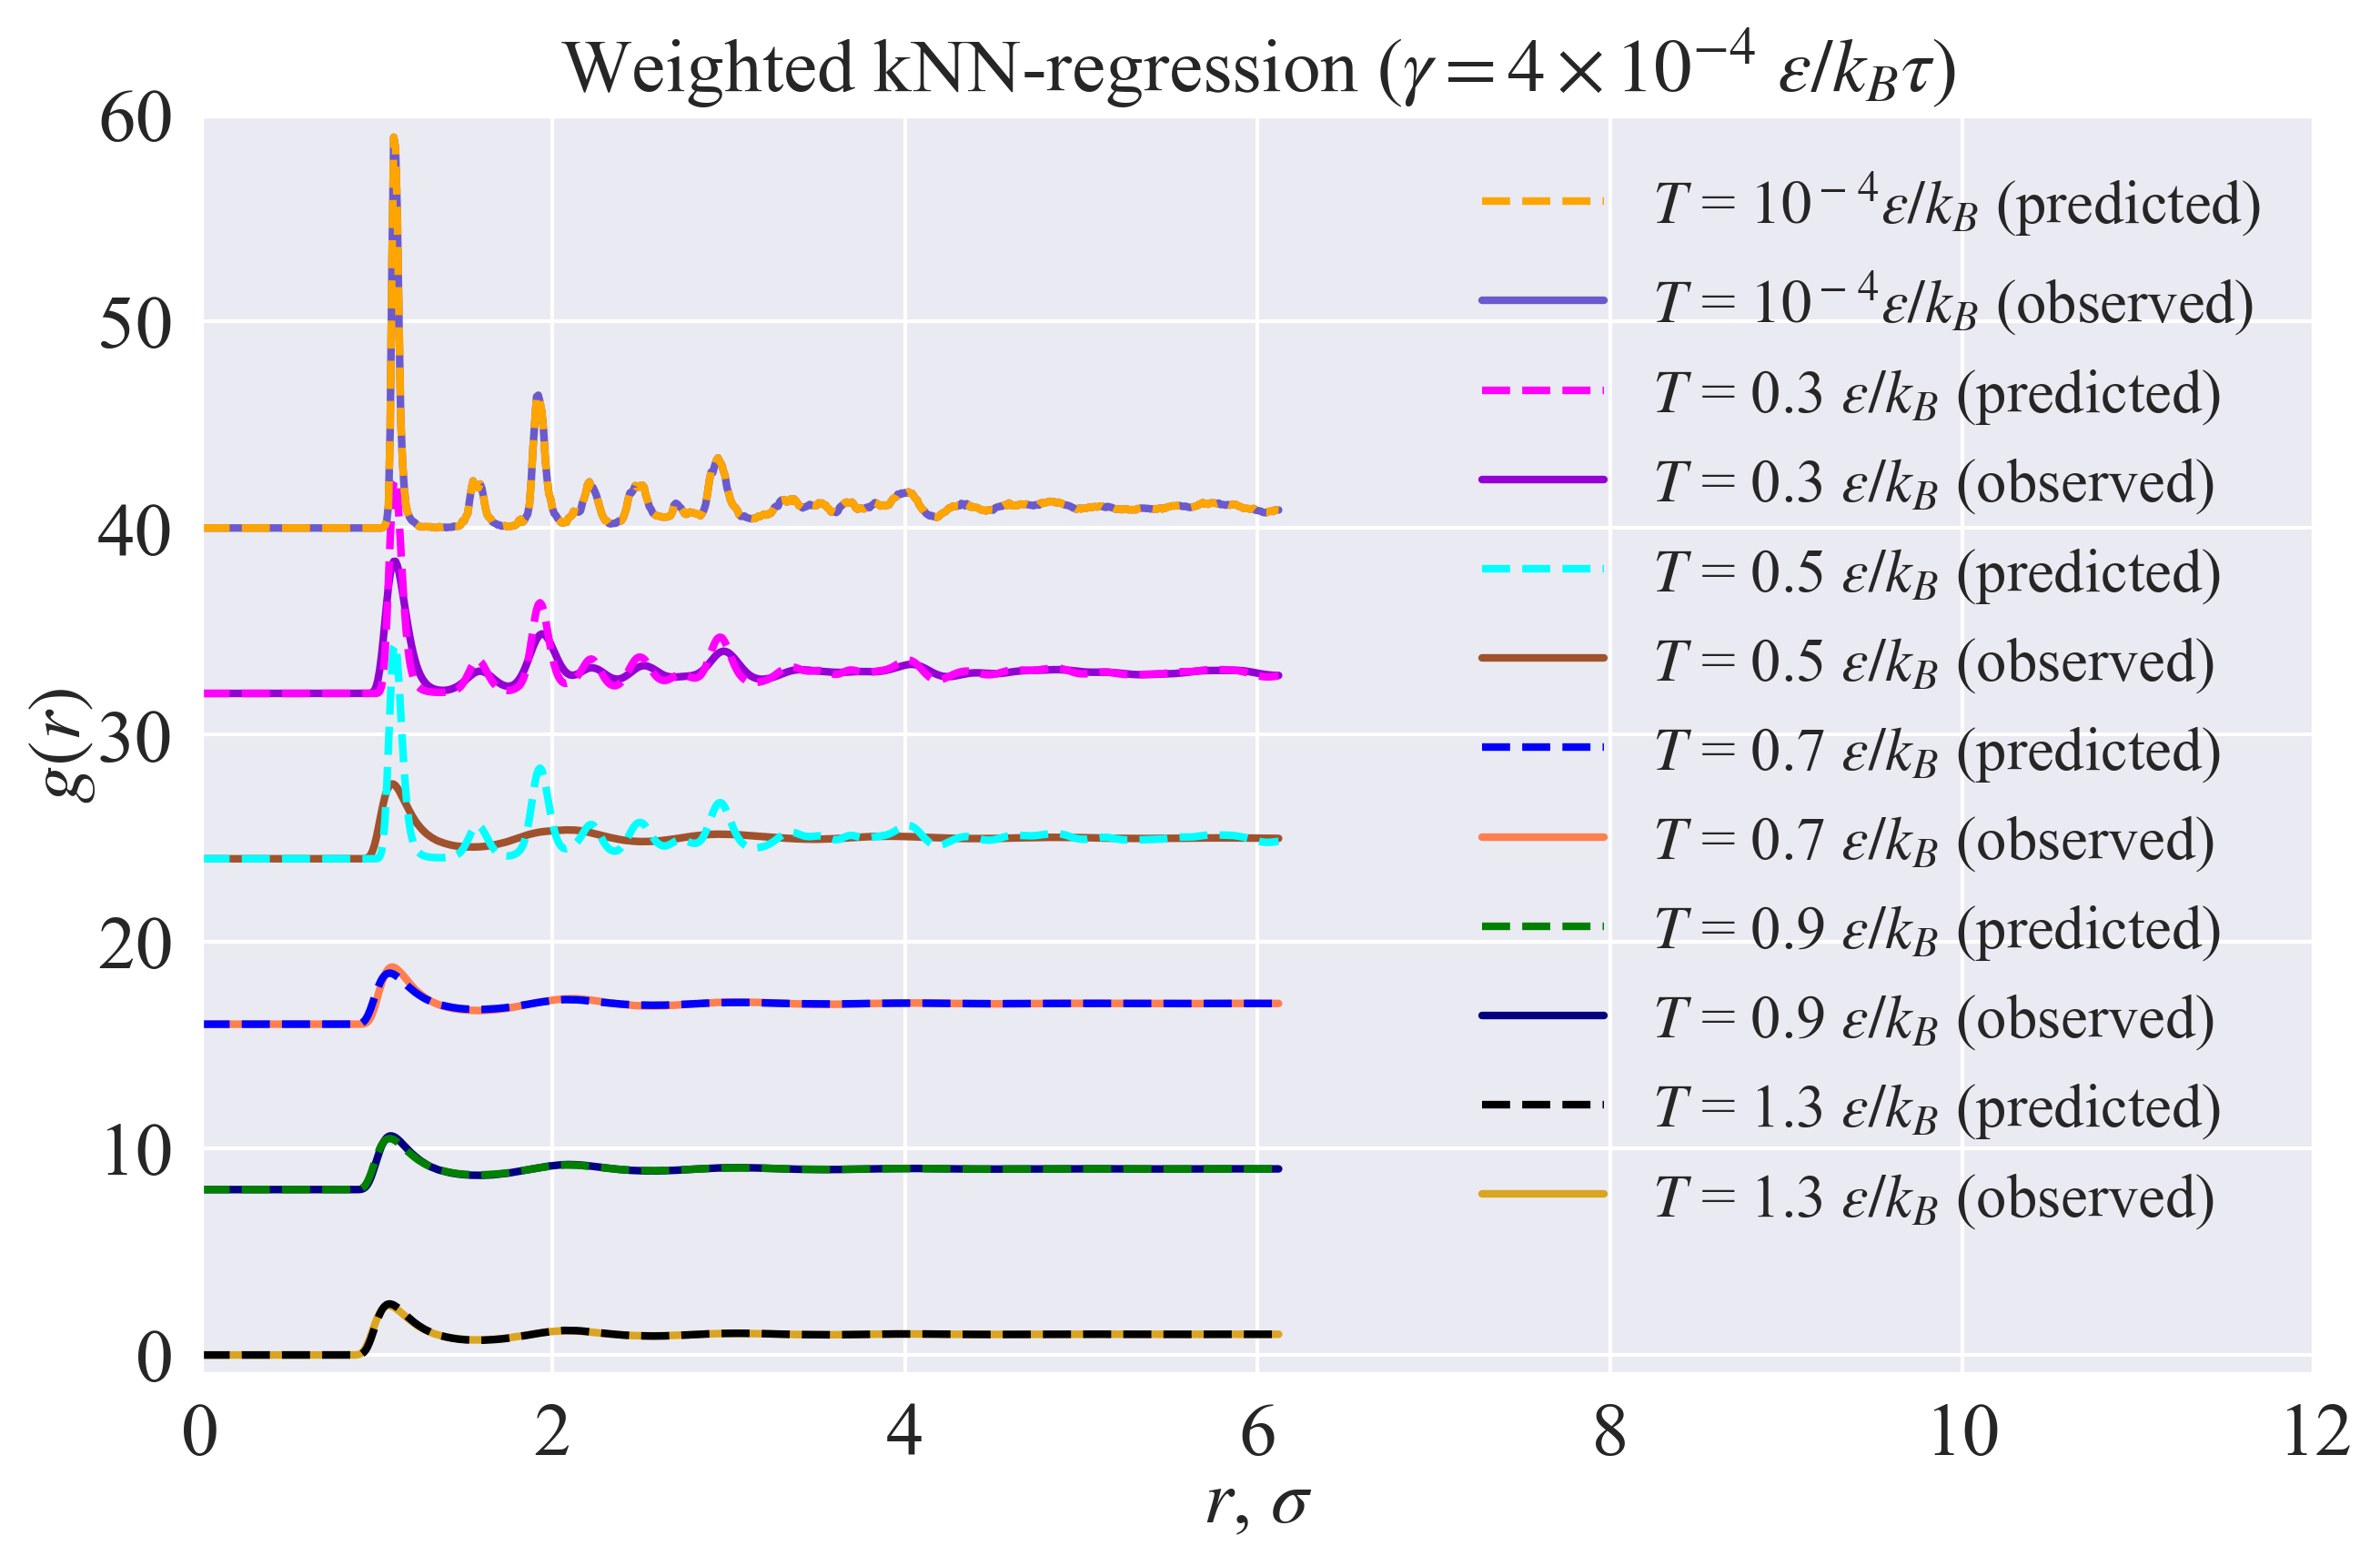

In [24]:
plotter = Plotter(
    path_to_plots=PATH_TO_CURRENT_PLOTS,
    limits=dict(
        left=0,
        right=12,
        bottom=-1,
        top=60,
    ),
    size=(10, 6),
    labels=('radius', 'rdf'),
)
plotter.ax.set_title(fr'Weighted kNN-regression ($\gamma = 4\times10^{{-4}}~\varepsilon / k_B\tau$)')
shown_temperatures = []
setups_size = len(setups_slow)
for i, setup in enumerate(setups_slow[::-1]):
    temperature = setup["temperature"]
    if temperature not in predicted_temperatures:
        continue
    if round(temperature, 4) in shown_temperatures:
        continue
    else:
        shift_scale = 8
        plotter.ax.plot(
            rdf_slow.data['radius'],
            rdf_slow.data[f'setup_{setups_size - i - 1}'] + shift_scale * len(shown_temperatures),
            label=get_temperature_legend(temperature, 2) + ' (observed)',
            color=COLORS[setups_size - i],
        )
        plotter.ax.plot(
            rdf_table.columns.values,
            predicted_rdf_points['k_neighbors_distance'][temperature] + shift_scale * len(shown_temperatures),
            '--',
            label=get_temperature_legend(temperature, 2) + ' (predicted)',
            color=COLORS[i],
        )
        shown_temperatures.append(round(temperature, 4))
        
handles, labels = plotter.ax.get_legend_handles_labels()
plotter.get_legend(handles[::-1], labels[::-1], fontsize=16)
plotter.save_plot(f'rdf_with_predicted_cooling_knn_distance.png')
plt.show()

In [25]:
max_mse['names']

NameError: name 'max_mse' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
i = 0
for temperature, values in max_mse.items():
    if isinstance(temperature, float):
        x = list(range(len(values)))
        if temperature > 1e-2:
            ax.plot(x, values, label=fr'$T = {temperature:.2f}~\epsilon / k_B$', color=COLORS[i])
        else:
            ax.plot(x, values, label=fr'$T = 10^{{-4}}~\epsilon / k_B$', color=COLORS[i])
        i += 1
ax.set_xticks(x)
ax.set_xticklabels(max_mse['names'])
ax.set_xlabel('Regression models', fontsize=20)
ax.set_ylabel('Max MSE', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title(fr'$\gamma = 4\times10^{{-4}}~\varepsilon / k_B\tau$', fontsize=20)
ax.legend()
save_plot(f'max_mse.png')
plt.show()